In [1]:
#!pip install ultralytics
import pandas as pd
import numpy as np
import cv2
from ultralytics import YOLO
import IPython
from IPython.display import Video, display
%matplotlib inline
from tqdm.notebook import tqdm
import os

In [2]:
path = 'vehicle-counting.mp4'
video = cv2.VideoCapture(path)

In [3]:
cap = cv2.VideoCapture(path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video.get(cv2.CAP_PROP_FPS)
print("Video Resolution: {}x{} @ fps: {}".format(width, height,fps))
cap.release()

Video Resolution: 3840x2160 @ fps: 25.0


In [4]:
display(Video(data=path,height=540,width=960))

In [5]:
model = YOLO('yolov8x.pt')
dict_classes = model.model.names
print(dict_classes)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [6]:
class_IDS = [2, 3, 5, 7] 
for i in class_IDS:
    print(dict_classes[i])

car
motorcycle
bus
truck


In [7]:
scale = 80

In [8]:
cap = cv2.VideoCapture(path)
width1 = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height1 = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(width1 * scale / 100)
height = int(height1 * scale / 100)
print('[INFO] - Dim Scaled: ', (width, height))

[INFO] - Dim Scaled:  (3072, 1728)


In [9]:
def rescaler(frame,scale):
    width = int(frame.shape[1] * scale/100)
    height = int(frame.shape[0] * scale/100)
    dim = (width, height)   
    resized = cv2.resize(frame,dim,interpolation = cv2.INTER_AREA)
    return resized

In [10]:
i,frame=video.read()

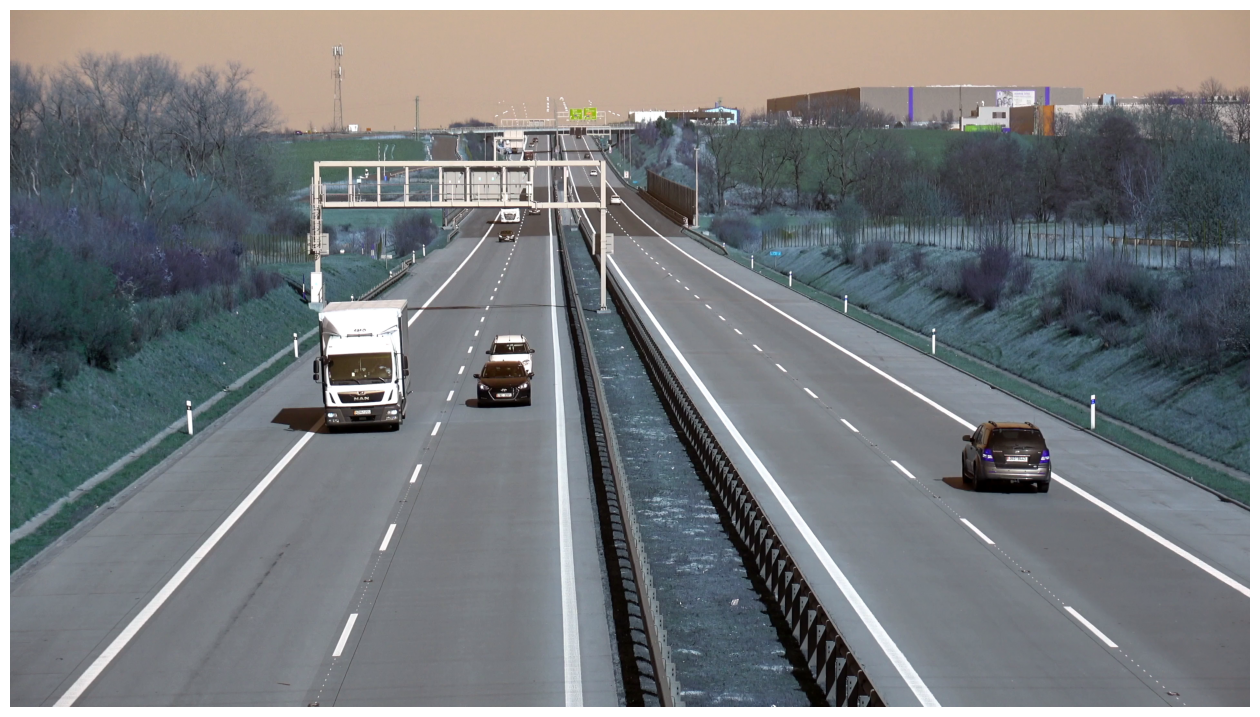

In [11]:
import matplotlib.pyplot as plt

def show_image(frame, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    plt.imshow(frame)
    plt.axis('off')
    plt.show()
show_image(frame, figsize=(16, 12))


class available in picture ['truck', 'car', 'car', 'car']
Location of Bounding Boxes in Picture:
[     935.17      895.11        1245      1308.2]
[     2940.1      1271.5      3225.5      1497.5]
[     1435.7      1084.6      1620.9      1230.7]
[     1477.3        1005      1630.8      1131.3]


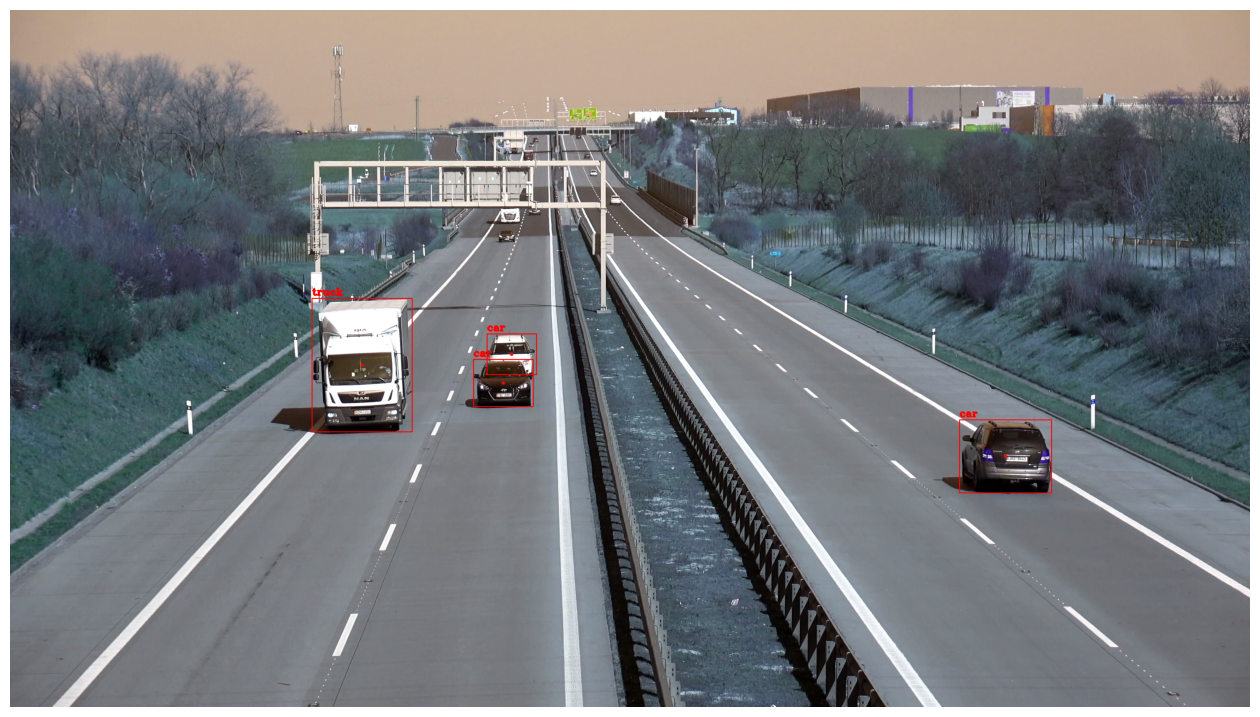

In [12]:
y_hat = model.predict(frame, conf=0.30, classes=class_IDS, device="cpu", verbose=False)
print('class available in picture',[dict_classes[i] for i in y_hat[0].boxes.cls.cpu().numpy()])
print('Location of Bounding Boxes in Picture:')
for box in y_hat[0].boxes.xyxy.cpu().numpy():
    print(box)
    
    
positions_frame = pd.DataFrame({
'xmin': y_hat[0].boxes.xyxy[:, 0].cpu().numpy(),
'ymin': y_hat[0].boxes.xyxy[:, 1].cpu().numpy(),
'xmax': y_hat[0].boxes.xyxy[:, 2].cpu().numpy(),
'ymax': y_hat[0].boxes.xyxy[:, 3].cpu().numpy(),
'conf': y_hat[0].boxes.conf.cpu().numpy(),
'class': y_hat[0].boxes.cls.cpu().numpy()
})

for ix, row in enumerate(positions_frame.iterrows()):
    xmin, ymin, xmax, ymax, conf, category =row[1].astype('int')
    center_x, center_y = int(((xmax+xmin))/2), int((ymax+ ymin)/2)
    cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
    cv2.circle(frame, (center_x,center_y), 5,(255,0,0),-1)
    cv2.putText(frame,text=dict_classes[category],org= (xmin,ymin-10),fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 0, 0),thickness=3)

    
show_image(frame, figsize=(16, 12))    

In [13]:
print('Total no of Frame in Video:',int(video.get(cv2.CAP_PROP_FRAME_COUNT)))

Total no of Frame in Video: 538


In [14]:
cy_linha = int(2*height/3)-140
cx_sentido = int((width/2)) ##### width by 2 for 2 way highway
offset = int(5 * scale/100 )

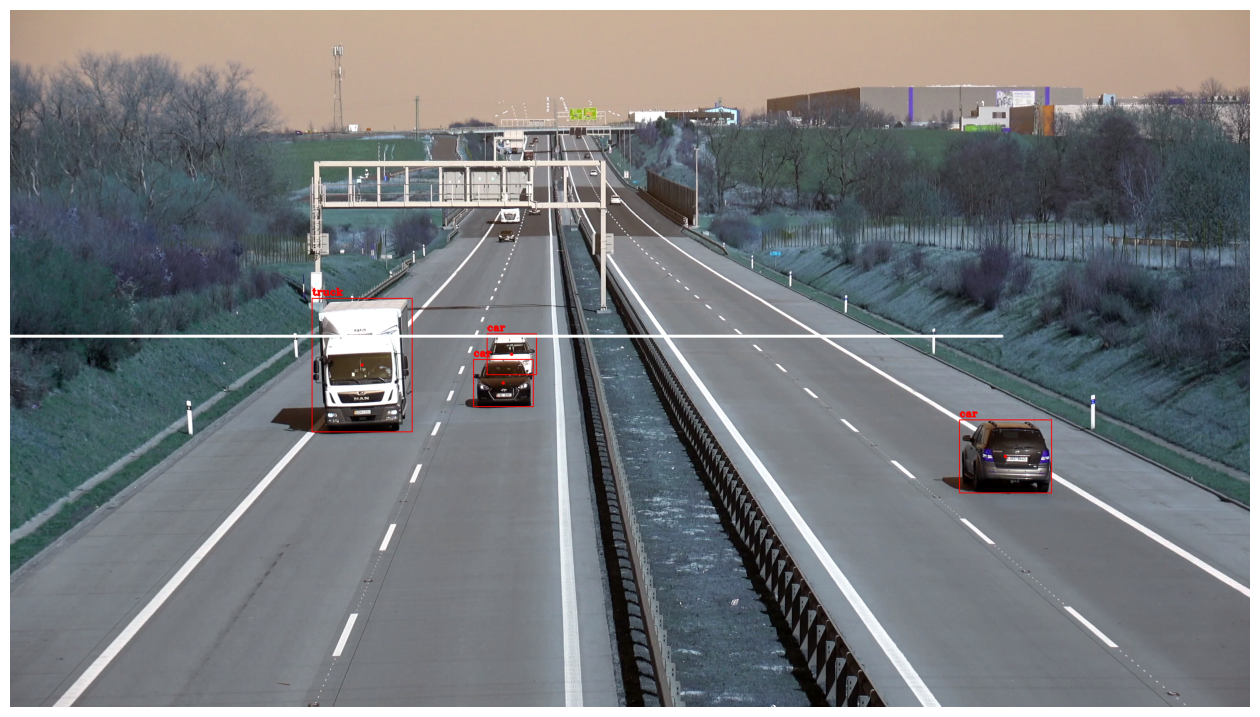

In [15]:
p = cv2.line(frame, (0, cy_linha), (width, cy_linha), (255,255,255), 8)
show_image(p, figsize=(16, 12))

In [16]:
centers_old = {}
centers_new = {}
obj_id = 0 
veiculos_contador_in = dict.fromkeys(class_IDS, 0)
veiculos_contador_out = dict.fromkeys(class_IDS, 0)
end = []
frames_list = []
contador_in = 0
contador_out = 0

In [17]:
print('Total no of Frame in Video:',int(video.get(cv2.CAP_PROP_FRAME_COUNT)))

Total no of Frame in Video: 538


In [18]:
video_name = 'result.mp4'
output_path = "rep_" + video_name
tmp_output_path = "tmp_" + output_path
VIDEO_CODEC = "MP4V"

output_video = cv2.VideoWriter(tmp_output_path, 
                               cv2.VideoWriter_fourcc(*VIDEO_CODEC), 
                               fps, (width, height))

In [19]:
for i in tqdm(range(int(video.get(cv2.CAP_PROP_FRAME_COUNT)))):
    ret, frame = video.read()
    if not ret:
        break
    frame = rescaler(frame, scale)
    y_hat = model.predict(frame, conf=0.30, classes=class_IDS, device="gpu", verbose=False)
    boxes   = y_hat[0].boxes.xyxy.cpu().numpy()
    conf    = y_hat[0].boxes.conf.cpu().numpy()
    classes = y_hat[0].boxes.cls.cpu().numpy()
    
    positions_frame = pd.DataFrame({
        'xmin': y_hat[0].boxes.xyxy[:, 0].cpu().numpy(),
        'ymin': y_hat[0].boxes.xyxy[:, 1].cpu().numpy(),
        'xmax': y_hat[0].boxes.xyxy[:, 2].cpu().numpy(),
        'ymax': y_hat[0].boxes.xyxy[:, 3].cpu().numpy(),
        'conf': y_hat[0].boxes.conf.cpu().numpy(),
        'class': y_hat[0].boxes.cls.cpu().numpy()
    })
    
    labels = [dict_classes[i] for i in classes]
    cv2.line(frame, (0, cy_linha), (width, cy_linha), (255,255,255), 8)
    
    for ix, row in enumerate(positions_frame.iterrows()):
        xmin, ymin, xmax, ymax, confidence, category = row[1].astype('int')
        center_x, center_y = int(((xmax+xmin))/2), int((ymax+ ymin)/2)
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
        cv2.circle(frame, (center_x, center_y), 5, (255,0,0), -1)
        cv2.putText(img=frame, text=labels[ix]+' - '+str(np.round(conf[ix],2)), org=(xmin, ymin-10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255,255,255), thickness=2)
        
        if (center_y < (cy_linha + offset)) and (center_y > (cy_linha - offset)):
            if (center_x >= 0) and (center_x <= cx_sentido):
                contador_in += 1
                veiculos_contador_in[category] += 1
            else:
                contador_out += 1
                veiculos_contador_out[category] += 1
                
    contador_in_plt = [f'{dict_classes[k]}: {i}' for k, i in veiculos_contador_in.items()]
    contador_out_plt = [f'{dict_classes[k]}: {i}' for k, i in veiculos_contador_out.items()]
    cv2.putText(img=frame, text='N. vehicles In', org=(30,80), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=2, color=(255, 255, 255), thickness=2)
    cv2.putText(img=frame, text='N. vehicles Out', org=(int(width-600 * scale/100 ),80), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=2, color=(255, 255, 255), thickness=2)
    xt = 40
    for txt in range(len(contador_in_plt)):
        xt += 200
        cv2.putText(img=frame, text=contador_in_plt[txt], org=(30,xt), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=2, color=(0,0, 255), thickness=2)
        cv2.putText(img=frame, text=contador_out_plt[txt], org=(int(width-600 * scale/100 ),xt), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=2, color=(0,0, 255), thickness=2)
    cv2.putText(img=frame, text=f'In:{contador_in}', org=(int((width/2) * scale/100 ),cy_linha+170), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=2, color=(255, 255, 255), thickness=2)
    cv2.putText(img=frame, text=f'Out:{contador_out}', org=(int((width/2) * scale/100 ),cy_linha), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=2, color=(255, 255, 255), thickness=2)
    output_video.write(frame)
output_video.release()


  0%|          | 0/538 [00:00<?, ?it/s]